# Portfolio 1

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE
import sklearn.metrics
from datetime import datetime

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [2]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert('Australia/Sydney')

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [3]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [4]:
ride_data = strava.join(cheetah)

In [5]:
allwork = ride_data[ride_data.workout_type == 'Workout']

In [6]:
ride_data.dropna(subset = ["device_watts"], inplace = True)

In [7]:
rd = ride_data.dropna()

In [8]:
rd = rd[rd.device_watts]

In [9]:
rd.drop(['filename', 'date'], axis = 1, inplace = True)

In [10]:
z=rd[['Distance', 'Time Moving' , 'Average Speed', 'Average Heart Rate', 'average_watts','NP', 'TSS', 'Elevation Gain' ]]
##scattermat = pd.plotting.scatter_matrix(z, marker = ".", diagonal='kde', figsize=(15,15), grid = True)

In [11]:
rd.drop(['elapsed_time', 'moving_time'], axis = 1, inplace=True)

In [12]:
mins = rd.Duration/60
rd['Duration_minutes'] = mins
rd.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elevation_gain,kudos,workout_type,time,axPower,...,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS,Duration_minutes
date,,,,,,,,,,,,,,,,,,,,,
2018-01-28 06:39:49+11:00,120.6,21.0,153.4,True,7.6,95.00 m,4,Ride,06:39:49,202.211,...,0.0,0.0,0.0,0.0,0.0,0.0,222.856,0.83155,20.2257,17.550000
2018-01-28 07:01:32+11:00,146.9,22.0,187.7,True,38.6,449.00 m,19,Race,07:01:32,226.039,...,0.0,0.0,0.0,0.0,0.0,0.0,245.365,0.91554,94.5787,67.700000
2018-02-06 08:06:42+11:00,119.3,19.0,165.9,True,24.3,439.00 m,6,Ride,08:06:42,221.672,...,0.0,0.0,0.0,0.0,0.0,0.0,253.702,0.94665,98.3269,69.183333
2018-02-07 17:59:05+11:00,124.8,20.0,151.0,True,47.1,890.00 m,10,Ride,17:59:05,218.211,...,0.0,0.0,0.0,0.0,0.0,0.0,232.644,0.86808,171.0780,144.316667
2018-02-10 06:18:03+11:00,123.0,20.0,145.9,True,59.8,656.00 m,22,Ride,06:18:03,189.918,...,0.0,0.0,0.0,0.0,0.0,0.0,212.726,0.79375,147.7970,193.950000


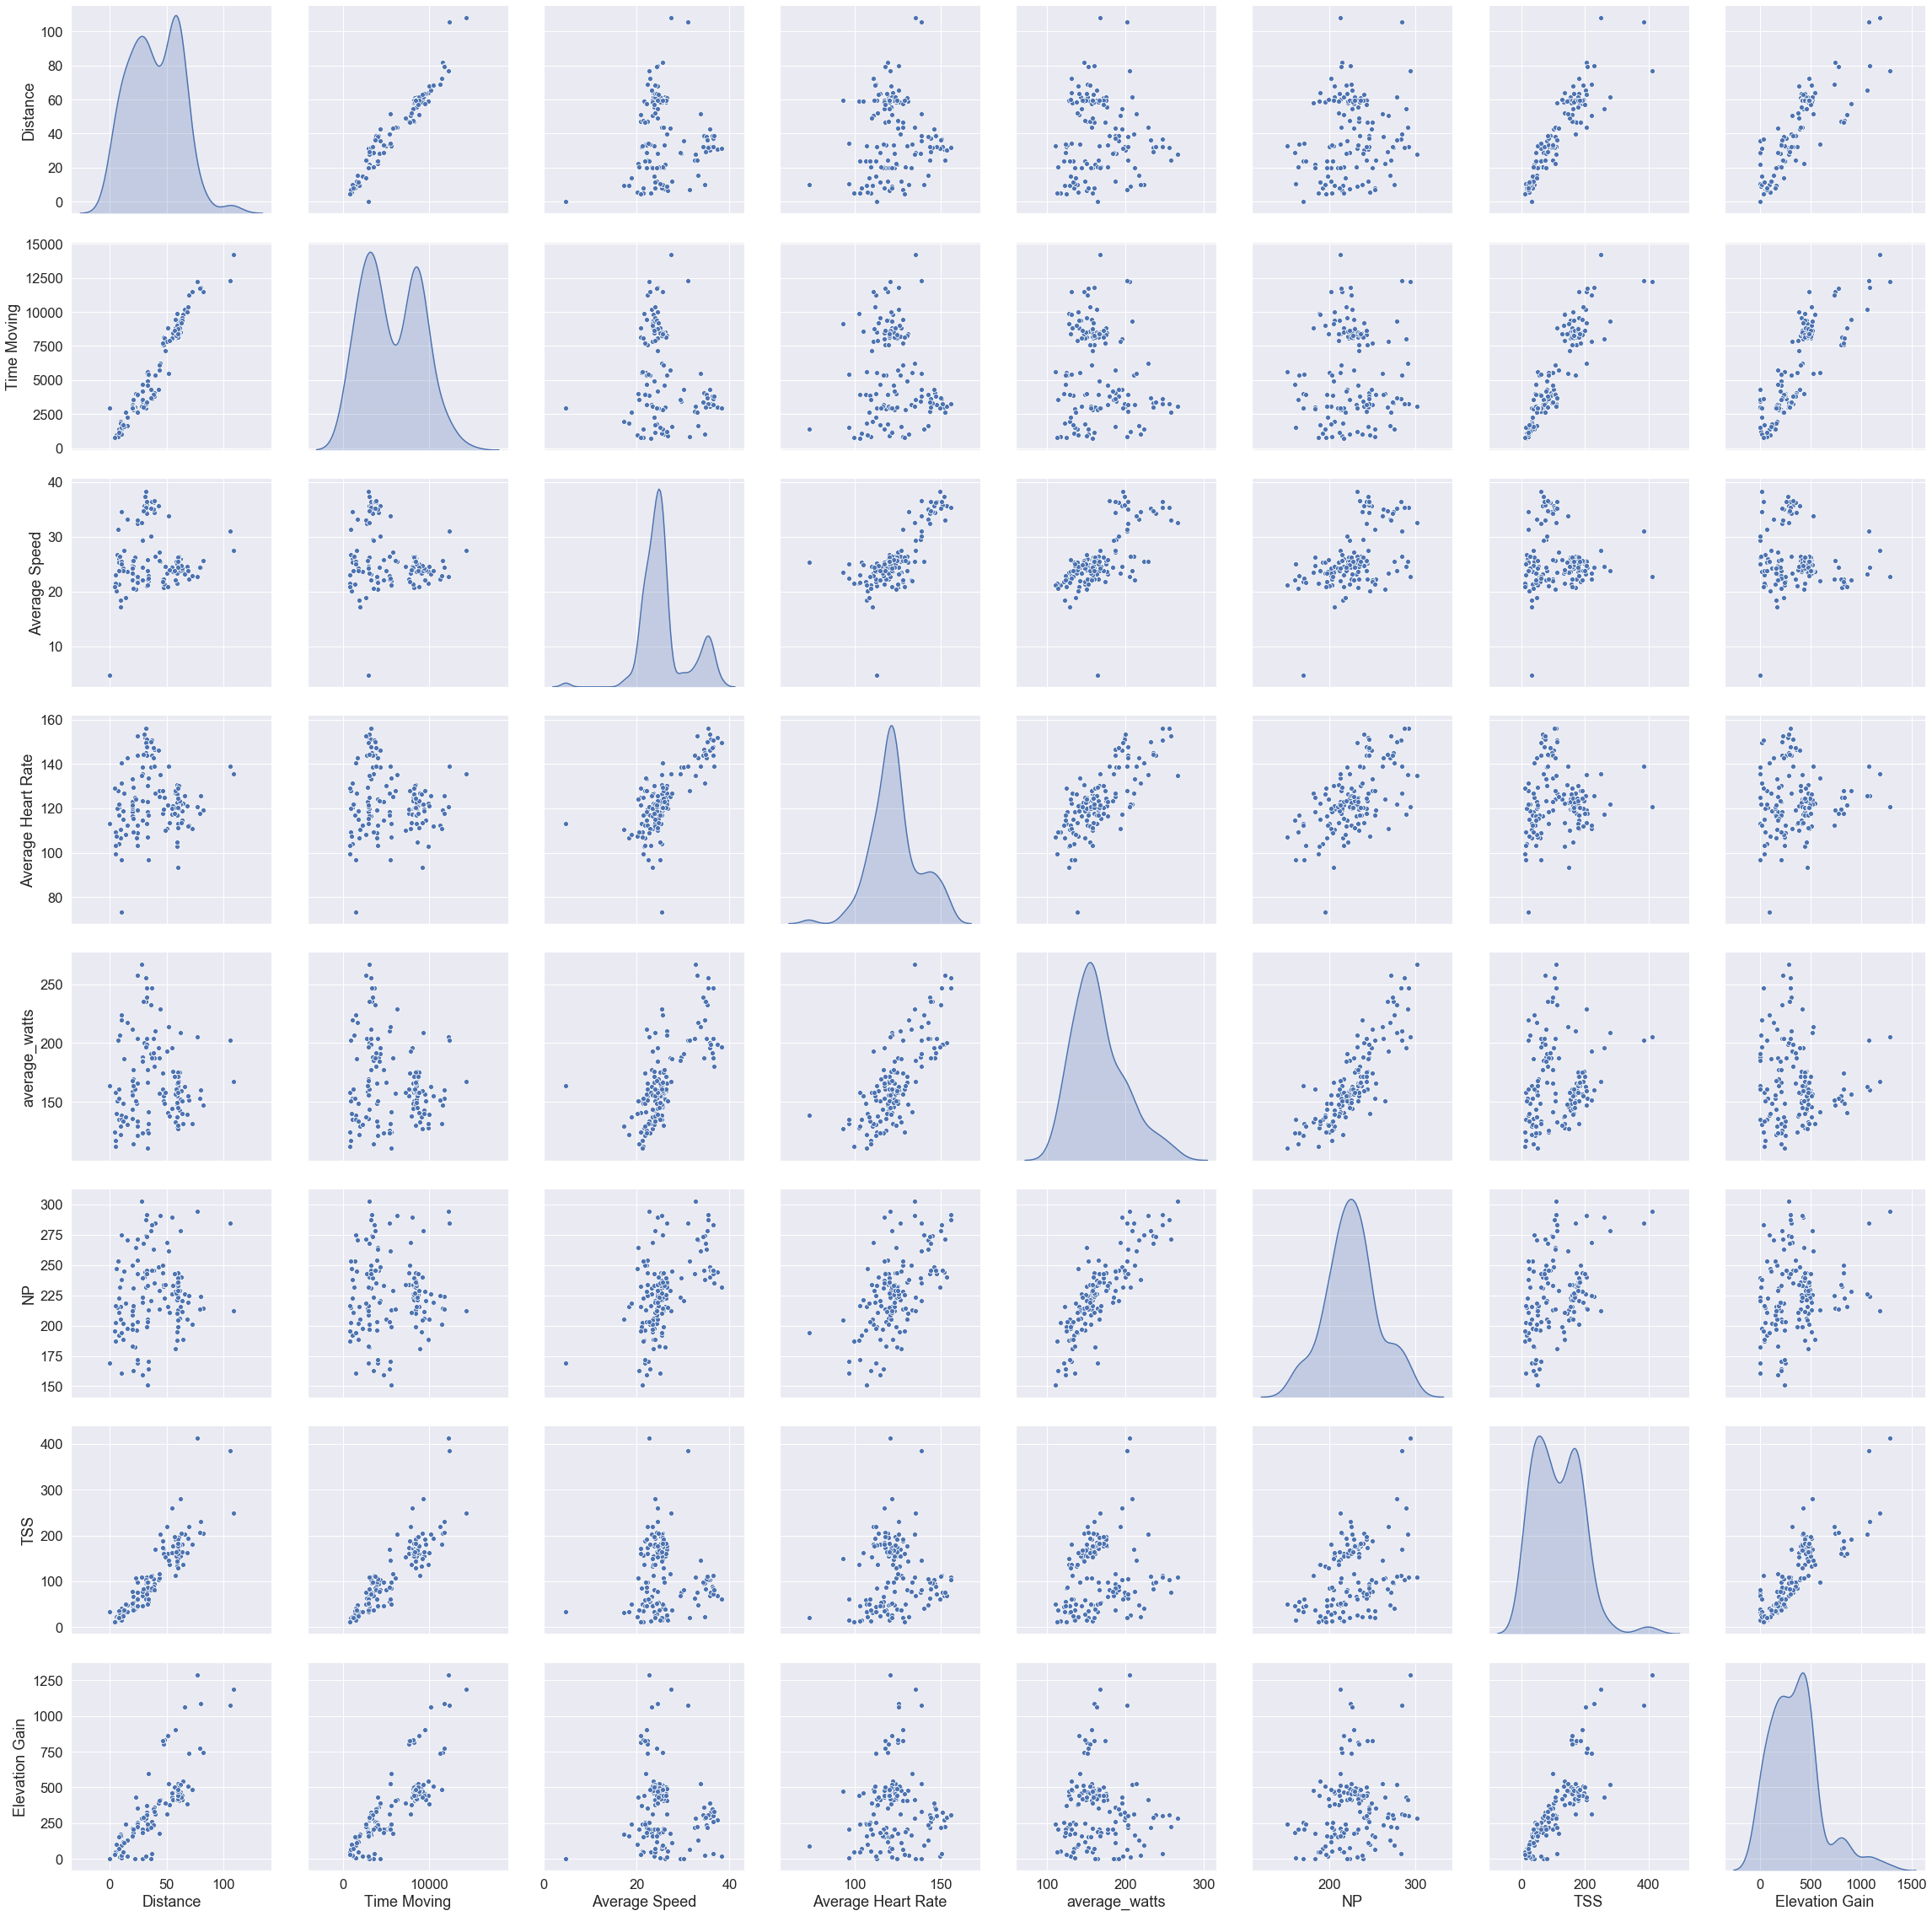

In [13]:
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
seapair = sns.pairplot(z, diag_kind='kde', palette= 'bright', height= 4)

## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


In [14]:
race = rd[rd.workout_type == "Race"]
ride = rd[rd.workout_type == "Ride"]
work= rd[rd.workout_type == "Workout"]
x = ['Distance', 'kudos', 'Time Moving', 'Average Heart Rate', 'Duration_minutes', 'Average Power', 'Work', 'Average Speed', 'Calories (HR)']

In [15]:
race = race[x]
ride = ride[x]
work = work[x]

# Analysis of Data #

## Scatterplots for Comparison of variables in Race, Ride and Workout ##

* ### Race ###

<Figure size 1800x720 with 0 Axes>

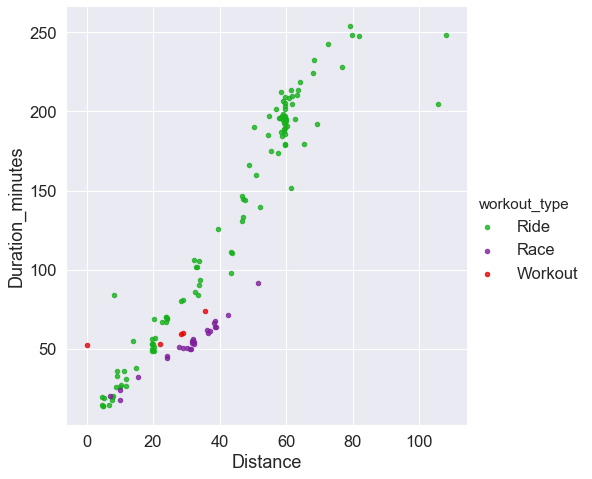

In [16]:
plt.figure(figsize = (25,10))
sns.set_style('darkgrid')
with sns.xkcd_palette(['green', 'purple', 'red']) :
    sns.lmplot(x = 'Distance', y = 'Duration_minutes', data = rd, fit_reg= False,
           hue = 'workout_type', legend_out= True, scatter_kws= {"s" : 20}, height = 7)

There is evidence of a **linear** relationship between the variables Distance and Duration for the category Race and Ride, however, we do not have enough data for Workouts to hypothesize a relationship between Duration and Distance. 

<Figure size 1800x720 with 0 Axes>

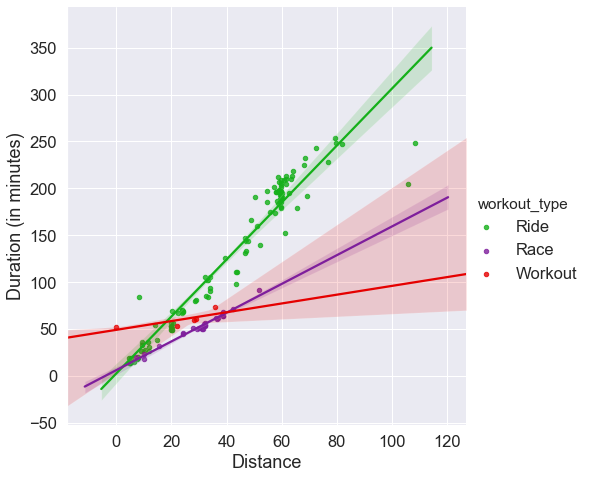

In [17]:
plt.figure(figsize = (25,10))
sns.set_style('darkgrid')
with sns.xkcd_palette(['green', 'purple', 'red']) :
    sns.lmplot(x = 'Distance', y = 'Duration_minutes', data = rd, fit_reg= True,
           hue = 'workout_type', legend_out= True, scatter_kws= {"s" : 20}, height = 7)
    plt.ylabel('Duration (in minutes)')

It is to be noted that the variable **x** is **Distance**, while variable **y** is **Duration**. It can be explained by the regression lines that as distance increases, so does duration. It is to be noted that the slope is highest for the category *Ride*, meaning that, the average speed during a Ride should be less compared to the other two variables. It can be assumed from the regression line that the average speed in a Race is higher than a Ride. It is also seen that Workout has the least slope, meaning, in theory it should have the highest average speed. But one should keep in mind that the Workout category only has 5 observations, and the distance and duration is much lesser than the other two categories, which is a contributing factor in a result that may be skewed

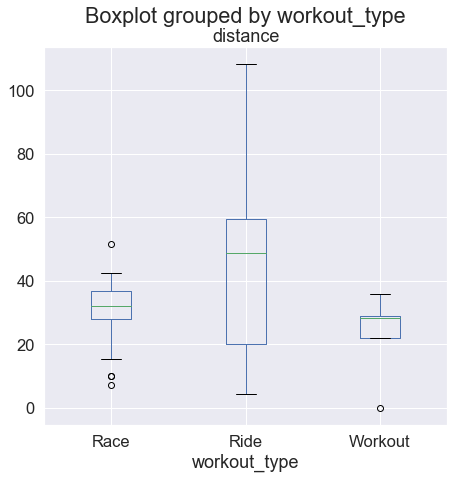

In [18]:
boxdist = rd.boxplot(by = 'workout_type', column = ['distance'], figsize = (7,7))

The category **ride** has the highest median distance covered per ride. It also has the highest range, meaning that it had a significant number of short and long distance rides. The median distace for **races** and **workouts** are almost the same, however, the spread for **races** is larger. They also have some outliers 

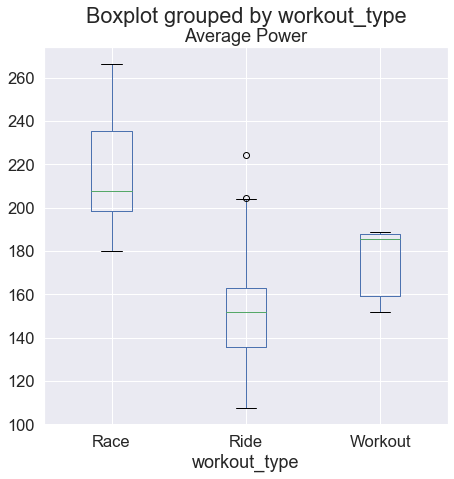

In [19]:
avgpowerbox = rd.boxplot(by = 'workout_type', column = ['Average Power'], figsize = (7,7))

Median power is the highest for **races**. The median for **workouts** is quite close to the maximum value, indicating that the power output was mostly high. However, it can be traced to the fact that the number of observations is quite low. **Rides** have the highest spread of power output, but have the lowest median

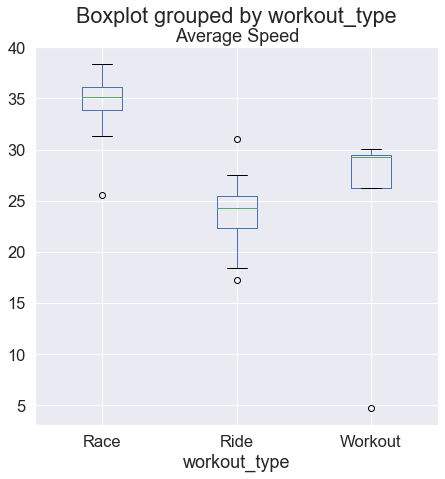

In [20]:
avgspeedbox = rd.boxplot(by = 'workout_type', column = ['Average Speed'], figsize = (7,7))

The distribution of speed is compact for all three categories. **Workouts** have the lowest spread, but have an outlier that is significantly less than its lower quartile. **Races** have the highest median value, whereas **rides** have the lowest median and highest spread

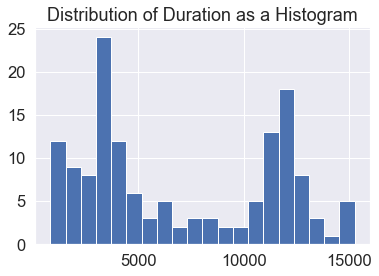

In [21]:
dur_hist = plt.hist(rd['Duration'], bins = 20)
z = plt.title("Distribution of Duration as a Histogram")

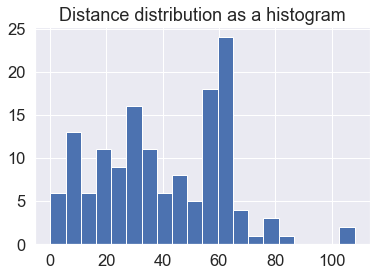

In [22]:
dist_hist = plt.hist(rd['Distance'], bins = 20)
z = plt.title("Distance distribution as a histogram")

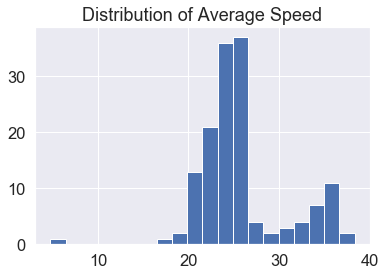

In [23]:
avg_speed_hist = plt.hist(rd['Average Speed'], bins = 20)
z = plt.title("Distribution of Average Speed")

The distribution of average speed is **skewed to the right**. This means that the **mean is higher than the median** of the data. The number of high average speed rides were significantly less, which resulted in a high mean, but did not affect the median value much

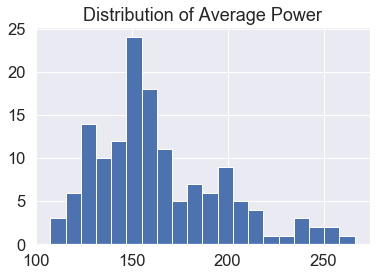

In [24]:
avg_power_hist = plt.hist(rd['Average Power'], bins = 20)
z = plt.title("Distribution of Average Power")

The distribution for average power is **normally distributed**

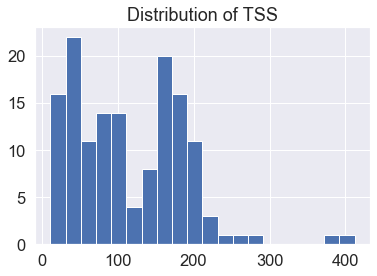

In [25]:
tss_hist = plt.hist(rd['TSS'], bins = 20)
z = plt.title("Distribution of TSS")

The distribution for training stress score is **bimodal**. There are some high scored observations, but their frequency is quite low

In [26]:
rd['Month'] = rd.index.month

In [27]:
months = {1:'January', 2 : 'February', 3 : 'March', 4: 'April', 5:'May', 6: 'June', 7: 'July', 8 : 'August', 9 : 'September', 10 : 'October', 11: 'November', 12: 'December'}
rd['Month'] = rd['Month'].map(months)

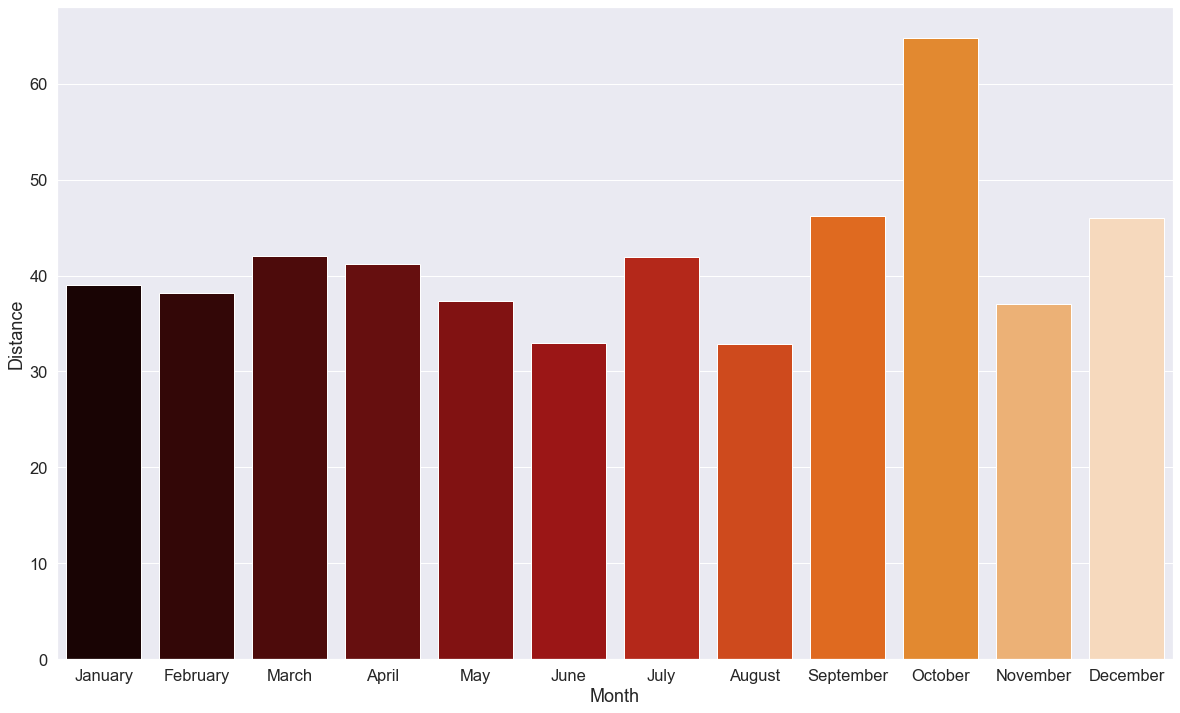

In [28]:
plt.figure(figsize = (20,12))
sns.barplot(y = 'Distance', x = 'Month', data = rd, ci = None, orient='v', palette= 'gist_heat')

This graph shows the total distance ridden during each month. It can be noted that in **October**, over 60km was covered in bike rides. **June** and **August** had the least distance covered, with both measuring a little over 30km

In [29]:
kudos = rd['kudos']
feature_cols = np.array(['Distance', 'Time Moving', 'Average Heart Rate', 'Duration_minutes', 'Average Power', 'Work', 'Average Speed', 'Calories (HR)', 'Elevation Gain'])
X = rd[feature_cols]

In [30]:
estimator = LinearRegression()
selector  = RFE(estimator, 9)
selector = selector.fit(X, kudos)

In [31]:
pred = selector.predict(X)

In [32]:
sklearn.metrics.r2_score(pred, kudos)

0.6000135700590741

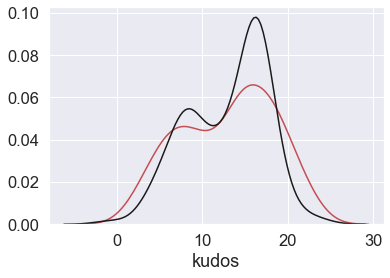

In [33]:
sns.distplot(kudos, hist = False, kde_kws={'color' : 'r'})
sns.distplot(pred, hist = False, kde_kws = {'color' : 'k'})

An $ R^2 $ score of $ 0.6 $ or $ 60 \%\ $ indicates that the predictor model is a decent fit of our actual model, although it does deviate from it at certain instances.

The **red** graph depicts the distribution of kudos from the actual data. The **black** graph depicts the prediction of kudos with the algorithm. It can be seen that the predictor follows the data closely upto most extent, except for a spike around **20** units, where our predictor's estimates are significantly higher than the actual model

In [34]:
supp = selector.get_support()

In [35]:
feature_cols[supp]

array(['Distance', 'Time Moving', 'Average Heart Rate',
       'Duration_minutes', 'Average Power', 'Work', 'Average Speed',
       'Calories (HR)', 'Elevation Gain'], dtype='<U18')

In [36]:
print("Regression Coefficients \n")
for i in range(len(feature_cols[supp])):
    print(feature_cols[supp][i] , ":", round(selector.estimator_.coef_[i], 5))

Regression Coefficients 

Distance : 0.22072
Time Moving : -0.00118
Average Heart Rate : 0.09509
Duration_minutes : 0.06356
Average Power : 0.0135
Work : -0.00042
Average Speed : 0.19804
Calories (HR) : -0.0035
Elevation Gain : 0.00316


**Distance** has a regression coefficient of 0.22, which implies that the change in value of distance has the most impact (out of these given variables), on the value of kudos.

In [37]:
months = []
for i in rd.index:
    months.append(str(i.month) + "/" + str(i.year))

In [38]:
months = np.array(months)

In [39]:
dat = rd[['TSS', 'Average Speed']]

In [40]:
dat = dat.reset_index()

In [41]:
dat['months'] = months

In [42]:
dat.drop('date', axis = 1, inplace = True)

In [43]:
tss_sum = dict()
for x in range(len(dat.months)):
    if (dat.months[x]) in tss_sum:
        tss_sum[dat.months[x]] += dat.TSS[x]
    else:
        tss_sum[dat.months[x]] = dat.TSS[x]

In [44]:
l1 = []
for i in tss_sum:
    for j in dat.months:
        if (i == j):
            l1.append(tss_sum[j])
list1 = []
for j in l1:
    x = j/100
    list1.append(x)

In [45]:
avg_spd = dict()
for x in range(len(dat.months)):
    if (dat.months[x]) in avg_spd:
        avg_spd[dat.months[x]] += dat['Average Speed'][x]
    else:
        avg_spd[dat.months[x]] = dat['Average Speed'][x]

In [46]:
counter = dict()
for i in dat.months:
    if i in counter:
        counter[i] += 1
    else:
        counter[i] = 1

In [47]:
avg_avg_speed = []
for i in avg_spd:
    avg_avg_speed.append(avg_spd[i]/counter[i])

In [48]:
l2 = []
for i in avg_spd:
    for j in dat.months:
        if (i == j):
            l2.append(avg_spd[j])

In [49]:
list2 = []
for i in l2:
    j = i/100
    list2.append(j)

In [50]:
dat['Monthly TSS Sum (in 100\'s)'] = list1

In [51]:
dat['Monthly Average Avg Speed (in 100 km/h)'] = list2

In [52]:
x = np.array(rd.Distance)
dat['Distance'] = x

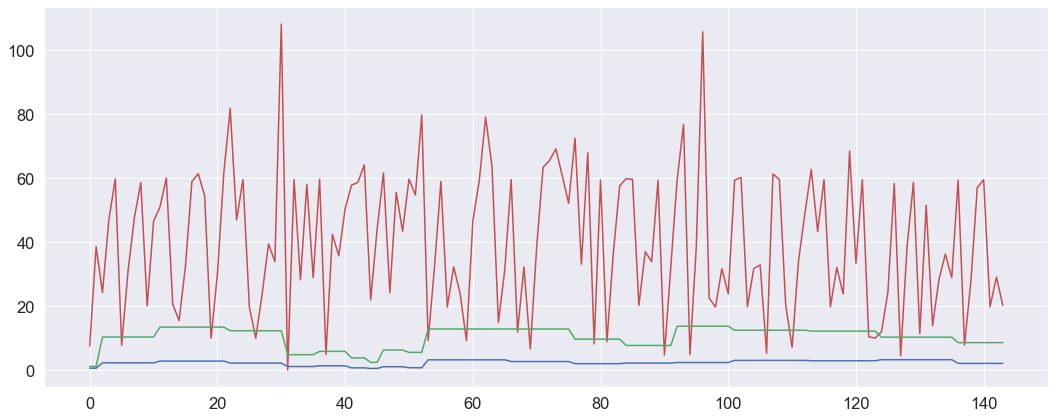

In [53]:
plt.figure(figsize = (18,7))
plt.plot(dat.index,dat['Distance'], c = 'r')
plt.plot(dat.index, dat['Monthly TSS Sum (in 100\'s)'], c = 'g')
plt.plot(dat.index, dat['Monthly Average Avg Speed (in 100 km/h)'])

In [54]:
kudos = pd.DataFrame(kudos)

In [55]:
weekday = kudos.index.weekday

In [56]:
weekstatus = []
for i in weekday:
    if (i > 5):
        weekstatus.append(0)
    else:
        weekstatus.append(1)
kudos['isWeekend'] = weekstatus
kudos['isWeekend'] = kudos['isWeekend'].astype('int64')

In [57]:
logreg = LogisticRegression(solver = 'liblinear')
feature_col = ['kudos']
X = kudos[feature_col]
y = kudos['isWeekend']
abc = logreg.fit(X,y)

In [58]:
probs = logreg.predict_proba(X)[:,1]

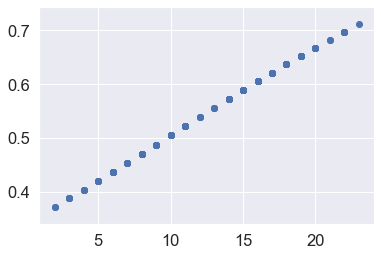

In [59]:
plt.scatter(X,probs)

In [60]:
feat_cols = np.append(feature_cols,'kudos')

In [61]:
feat_graph = rd[feat_cols]

In [62]:
feat_graph = feat_graph.corr()

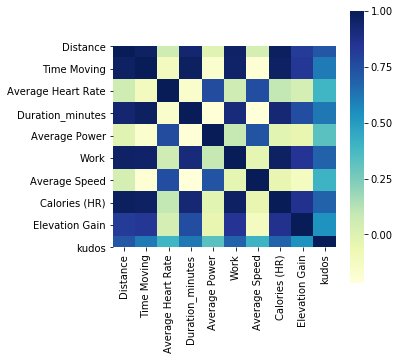

In [63]:
plt.figure(figsize = (5,5))
plt.style.use('default')
heatmap = sns.heatmap(feat_graph, square = True, cmap="YlGnBu")

The heatmap shows correlation of some of the key variables in the dataset. The darker shades imply a higher correlation value, as compared to lighter shades. Here, we are not concerned with the diagonal running from the top-left to the bottom right, as it just shows the correlation of each variable with itself (which is always 1). 

It is important to note that correlation does not imply causation. If two variables are correlated, it does not mean that one causes the other.

# --------------------------------------- *END OF PORTFOLIO 1* --------------------------------------

# Portfolio 2

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [65]:
energy = pd.read_csv("data/energydata_complete.csv", index_col = 'date', parse_dates = True)
testdat = pd.read_csv("data/testing.csv", index_col = 'date', parse_dates = True)
traindat = pd.read_csv("data/training.csv", index_col = 'date', parse_dates = True)

In [66]:
temp_sum = energy['T1'] + energy['T2'] + energy['T3'] + energy['T4'] + energy ['T5'] + energy ['T6'] + energy ['T7'] + energy ['T8'] + energy ['T9']
temp_avg = temp_sum/9
energy['Average_Temperature'] = temp_avg

In [67]:
energy.rename(columns = {"T1" : "T_Kitchen", "T2" : "T_LRoom", "T3" : "T_Laundry", "T4" : "T_Office", "T5" : "T_Bath", "T6" : "T_North", "T7" : "T_Iron" , "T8" : "T_Teen" , "T9" : "T_Parents"}, inplace = True)

In [68]:
energy.rename(columns = {"R1" : "R_Kitchen", "R2" : "R_LRoom", "R3" : "R_Laundry", "R4" : "R_Office", "R5" : "R_Bath", "R6" : "North", "R7" : "R_Iron", "R8" : "R_Teen", "R9" : "R_Parents"}, inplace = True)

In [69]:
energy.rename(columns = {"Visibility" : "Visibility (in km)", "Windspeed" : "Windspeed in m/s"}, inplace = True)

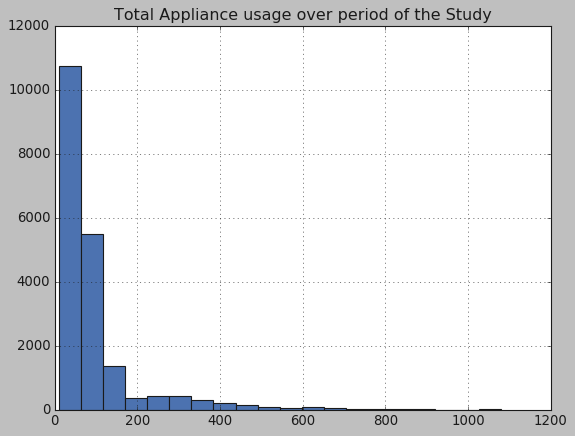

In [70]:
plt.style.use('classic')
energy['Appliances'].hist(bins = 20)
x = plt.title("Total Appliance usage over period of the Study")

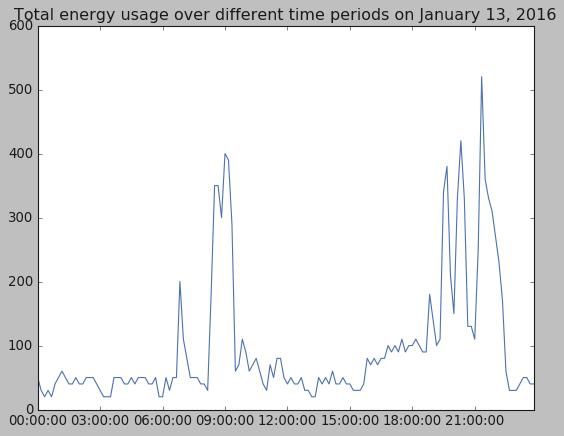

In [71]:
ax1 = plt.plot(energy.Appliances['2016-01-13'])
x = plt.title("Total energy usage over different time periods on January 13, 2016")

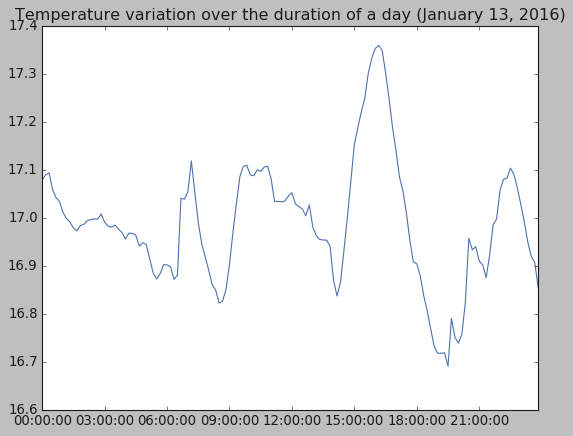

In [72]:
x = plt.plot(energy.Average_Temperature['2016-01-13'])
x = plt.title("Temperature variation over the duration of a day (January 13, 2016)")

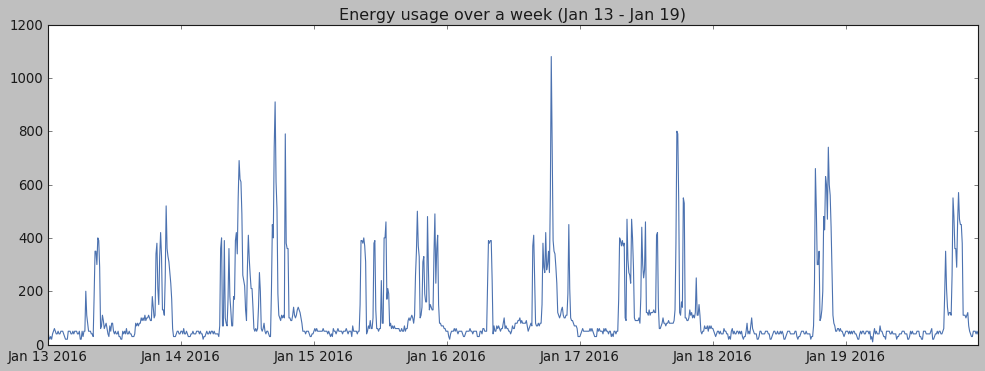

In [73]:
plt.figure(figsize = (15,5))
x = plt.plot(energy.Appliances['2016-01-13':'2016-01-19'])
x = plt.title("Energy usage over a week (Jan 13 - Jan 19)")

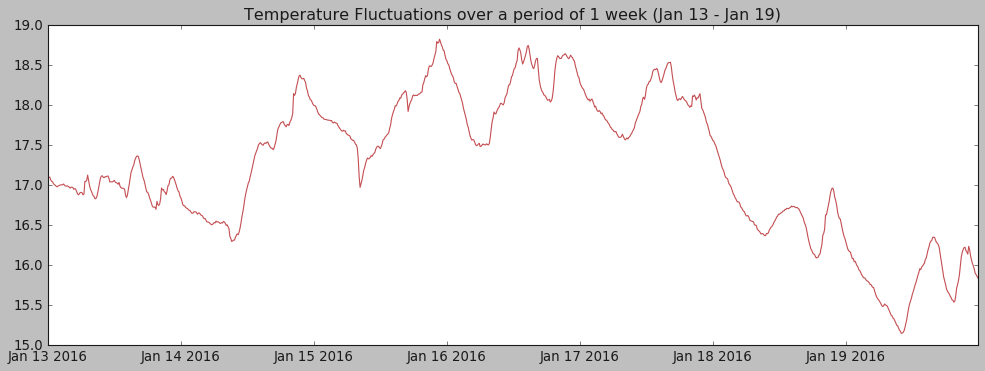

In [74]:
plt.figure(figsize = (15,5))
x = plt.plot(energy.Average_Temperature['2016-01-13':'2016-01-19'], c = 'r')
x  =plt.title("Temperature Fluctuations over a period of 1 week (Jan 13 - Jan 19)")

In [75]:
energy['Weekday'] = energy.index.weekday

In [76]:
energy.Weekday = energy['Weekday'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'})

In [77]:
energy['Weekday'] = energy.Weekday.astype('category')

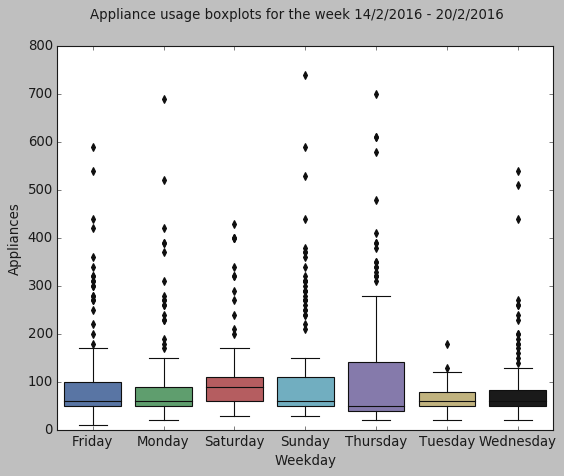

In [78]:
z = sns.boxplot(x = 'Weekday', y = 'Appliances', data = energy['2016-02-14':'2016-02-20'])
x = plt.suptitle("Appliance usage boxplots for the week 14/2/2016 - 20/2/2016")

If we ignore the outliers, it can be noted that during the week from **14 February 2016 to 20 February 2016**, it can be seen that the median energy usage appears to be the highest during Saturday. The spread of appliance usage is highest on Thursday, indicating that there may be times when appliance usage may be significantly high or low.

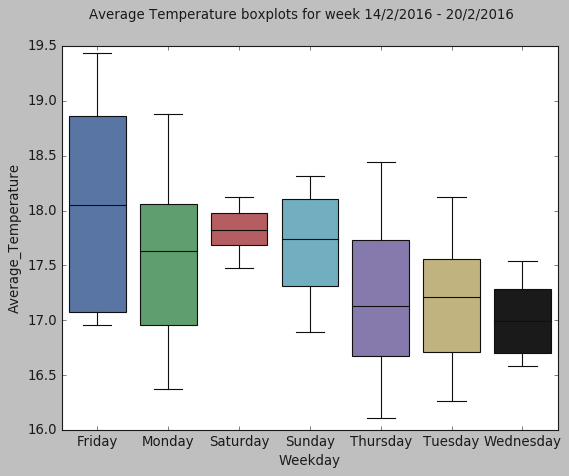

In [79]:
bx = sns.boxplot(x = 'Weekday', y = 'Average_Temperature', data = energy['2016-02-14':'2016-02-20'])
x = plt.suptitle("Average Temperature boxplots for week 14/2/2016 - 20/2/2016")

By looking at the average temperature boxplots, for the same week, it can be seen that the highest median temperature was recorded on **Friday (~18°C)**. Friday also displayed the largest temperature range. The least median temperature was recorded on **Wednesday(~17.1°C)**, but the lowest temperature throughout the week was observed on **Thursday(~16.2°C)**.

The most temperature fluctuations (range) were observed on **Friday** and **Monday**, whereas the least temperature fluctuations were observed on **Saturday**.

In [80]:
traindat['isMon'] = (traindat.Day_of_week == "Monday").astype("int64")
traindat["isTue"] = (traindat.Day_of_week == "Tuesday").astype("int64")
traindat["isWed"] = (traindat.Day_of_week == "Wednesday").astype("int64")
traindat["isThu"] = (traindat.Day_of_week == "Thursday").astype("int64")
traindat["isFri"] = (traindat.Day_of_week == "Friday").astype("int64")
traindat["isSat"] = (traindat.Day_of_week == "Saturday").astype("int64")
traindat["isSun"] = (traindat.Day_of_week == "Sunday").astype("int64")

In [81]:
testdat['isMon'] = (testdat.Day_of_week == "Monday").astype("int64")
testdat["isTue"] = (testdat.Day_of_week == "Tuesday").astype("int64")
testdat["isWed"] = (testdat.Day_of_week == "Wednesday").astype("int64")
testdat["isThu"] = (testdat.Day_of_week == "Thursday").astype("int64")
testdat["isFri"] = (testdat.Day_of_week == "Friday").astype("int64")
testdat["isSat"] = (testdat.Day_of_week == "Saturday").astype("int64")
testdat["isSun"] = (testdat.Day_of_week == "Sunday").astype("int64")

In [82]:
wkd = []
for day in traindat.Day_of_week:
    if day == "Saturday" or day == "Sunday":
        wkd.append(1)
    else:
        wkd.append(0)
traindat["isWeekend"] = wkd

In [83]:
feat_cols = np.array(['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'NSM', 'isMon',
       'isTue', 'isWed', 'isThu', 'isFri', 'isSat', 'isSun', 'isWeekend'])

In [84]:
X = traindat[['NSM']]
y = traindat['Appliances']

In [85]:
linmod = LinearRegression()
linmod.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
yPred = linmod.predict(X)

In [87]:
print("Equation for line: y = " , linmod.coef_ , "*x + ", linmod.intercept_ , "\n")
print("MSE: ", metrics.mean_squared_error(y, yPred), "\n")
print("R_Squared Value :", metrics.r2_score(y,yPred))

Equation for line: y =  [0.00089024] *x +  59.74354436037471 

MSE:  10078.837234153812 

R_Squared Value : 0.04672801435837293


Text(0.5, 1, 'Linear Model on Training Data')

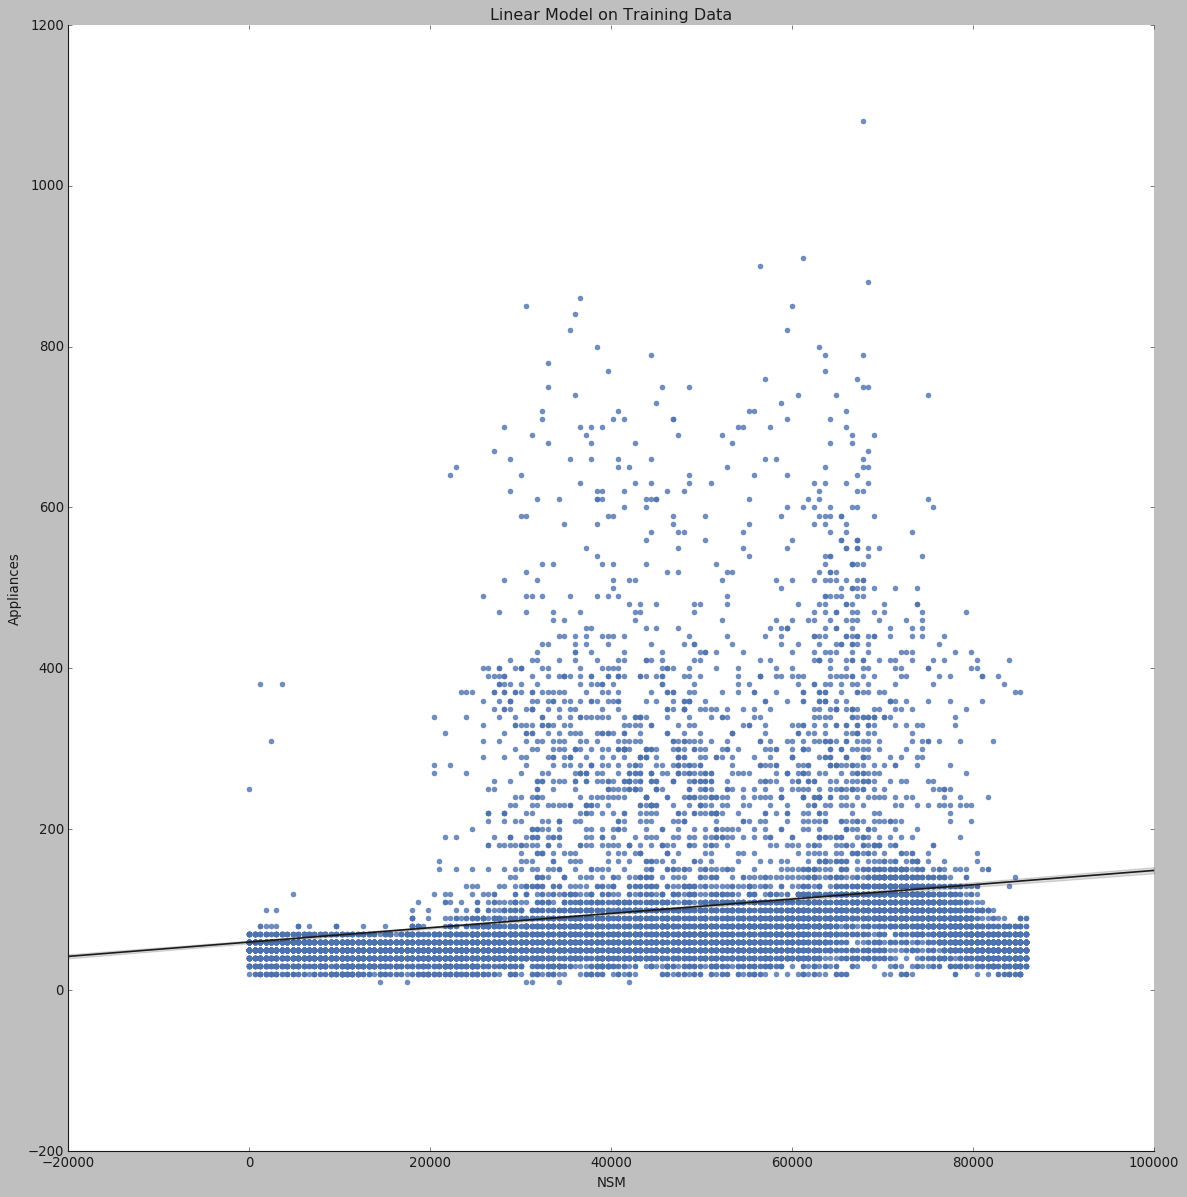

In [88]:
sns.lmplot("NSM", "Appliances", data = traindat, height = 15, line_kws = {'color' : 'k'})
plt.title('Linear Model on Training Data')

### Equation of line :$ y = 0.000890*x +  59.743544 $
 
### RMSE : $ 100.393412 $ 

### $ R^2 : 0.046728 $

In [89]:
X_test = testdat[['NSM']]
y_test = testdat['Appliances']

In [90]:
test_Pred = linmod.predict(X_test)

In [91]:
print("MSE: ", metrics.mean_squared_error(y_test, test_Pred), "\n")
print("R_Squared Value :", metrics.r2_score(y_test,test_Pred))

MSE:  9824.383570322969 

R_Squared Value : 0.04833203146208631


Text(0.5, 1, 'Linear Model on Test Data')

<Figure size 2000x960 with 0 Axes>

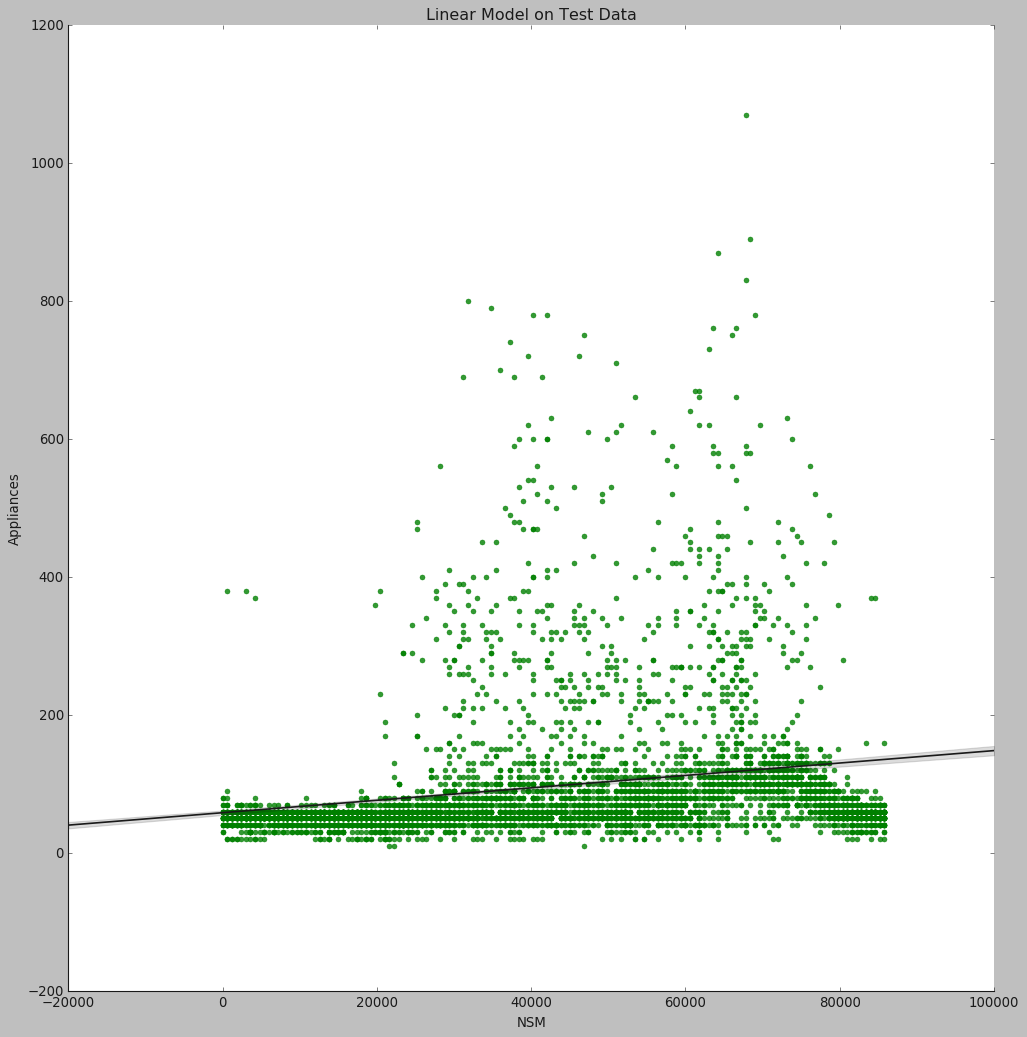

In [92]:
plt.figure(figsize=(25,12))
sns.lmplot(x = "NSM", y = "Appliances", data = testdat, height=13, line_kws={"color" : "k"}, scatter_kws={'color' : 'green'})
plt.title('Linear Model on Test Data')

### RMSE : $ 99.118028 $ 

### $ R^2 : 0.048332 $

As both training and test data show a poor $ R^2 $ score and low MSE, we can conclude that a linear model is not a suitable predictor for our variable

In [93]:
estimator = LinearRegression()
selector = RFE(estimator, 36)

In [94]:
X_rfe = traindat[feat_cols]
y_rfe = traindat['Appliances']
selector = selector.fit(X_rfe,y_rfe)

In [95]:
supp = selector.get_support()
z =  feat_cols[supp]
y = selector.estimator_.coef_
for i in range(len(z)):
    print(z[i] , ' : ', y[i])


lights  :  1.8555300572753333
T1  :  -5.918458887795787
RH_1  :  14.513309248462757
T2  :  -17.895403255728255
RH_2  :  -13.839892792250808
T3  :  26.373119272133245
RH_3  :  6.286728345196197
T4  :  0.9338873552096364
RH_4  :  -0.4808704727095342
T5  :  -1.4708780710905738
RH_5  :  0.06675184021258274
T6  :  7.068762906900168
RH_6  :  0.2906511325690933
T7  :  1.4078864017239145
RH_7  :  -1.6236138301042309
T8  :  8.340649778295214
RH_8  :  -4.1347710362641585
T9  :  -13.031861938673432
RH_9  :  -0.38320090623073777
T_out  :  -9.690754180015858
Press_mm_hg  :  0.18113708762148614
RH_out  :  -0.780586659595551
Windspeed  :  1.7874538298006504
Visibility  :  0.18714419612804187
Tdewpoint  :  3.6242496528142945
rv1  :  -0.024119062230549753
rv2  :  -0.024119062230530657
NSM  :  0.00028811858541022417
isMon  :  4.739353196362917
isTue  :  -9.365794134954086
isWed  :  -5.871791977020701
isThu  :  -6.151165858923285
isFri  :  10.934531349796586
isSat  :  11.010081279774976
isSun  :  -5.2952

In [96]:
rfe_pred = selector.predict(X_rfe)

In [97]:
print("R-Squared value : ",metrics.r2_score(y_rfe, rfe_pred))

R-Squared value :  0.17834376492372528


In [98]:
traindat.isMon = (traindat["isMon"]).astype("category")
traindat.isTue = (traindat["isTue"]).astype("category")
traindat.isWed = (traindat["isWed"]).astype("category")
traindat.isThu = (traindat["isThu"]).astype("category")
traindat.isFri = (traindat["isFri"]).astype("category")
traindat.isSat = (traindat["isSat"]).astype("category")
traindat.isSun = (traindat["isSun"]).astype("category")
traindat.isWeekend = (traindat["isWeekend"]).astype("category")
feat_cats = ['isMon','isTue', 'isWed', 'isThu', 'isFri', 'isSat', 'isSun', 'isWeekend']

In [99]:
times = []
for i in energy.index:
    times.append(datetime.time(i))
energy['Time'] = times

In [100]:
nrg_heatmap = energy[['Weekday', 'Time', 'Appliances']][::6]

In [101]:
from pandas.api.types import CategoricalDtype
nrg_grp = nrg_heatmap.groupby(['Weekday', 'Time'], as_index=False).mean()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories = cats, ordered = True)
nrg_grp['Weekday'] = (nrg_grp['Weekday'].astype(cat_type))

In [102]:
nrg_grp = nrg_grp.pivot(index = 'Time', columns='Weekday')

Text(0.5, 1, 'Heatmap showing hourly appliance usage')

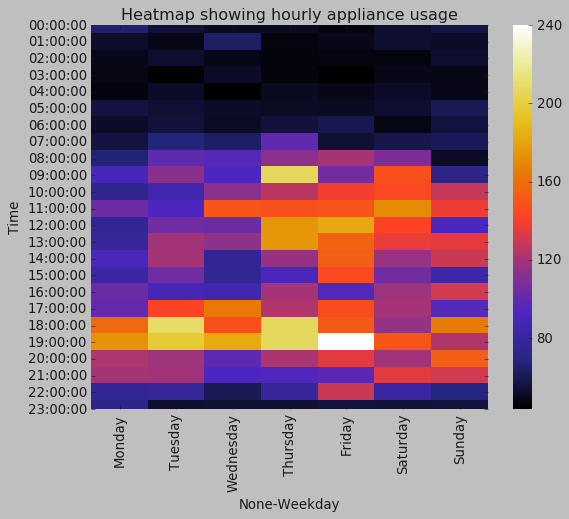

In [103]:
plt.style.use('classic')
heatmap = sns.heatmap(nrg_grp, cmap = "CMRmap", xticklabels=cats)
plt.title("Heatmap showing hourly appliance usage")


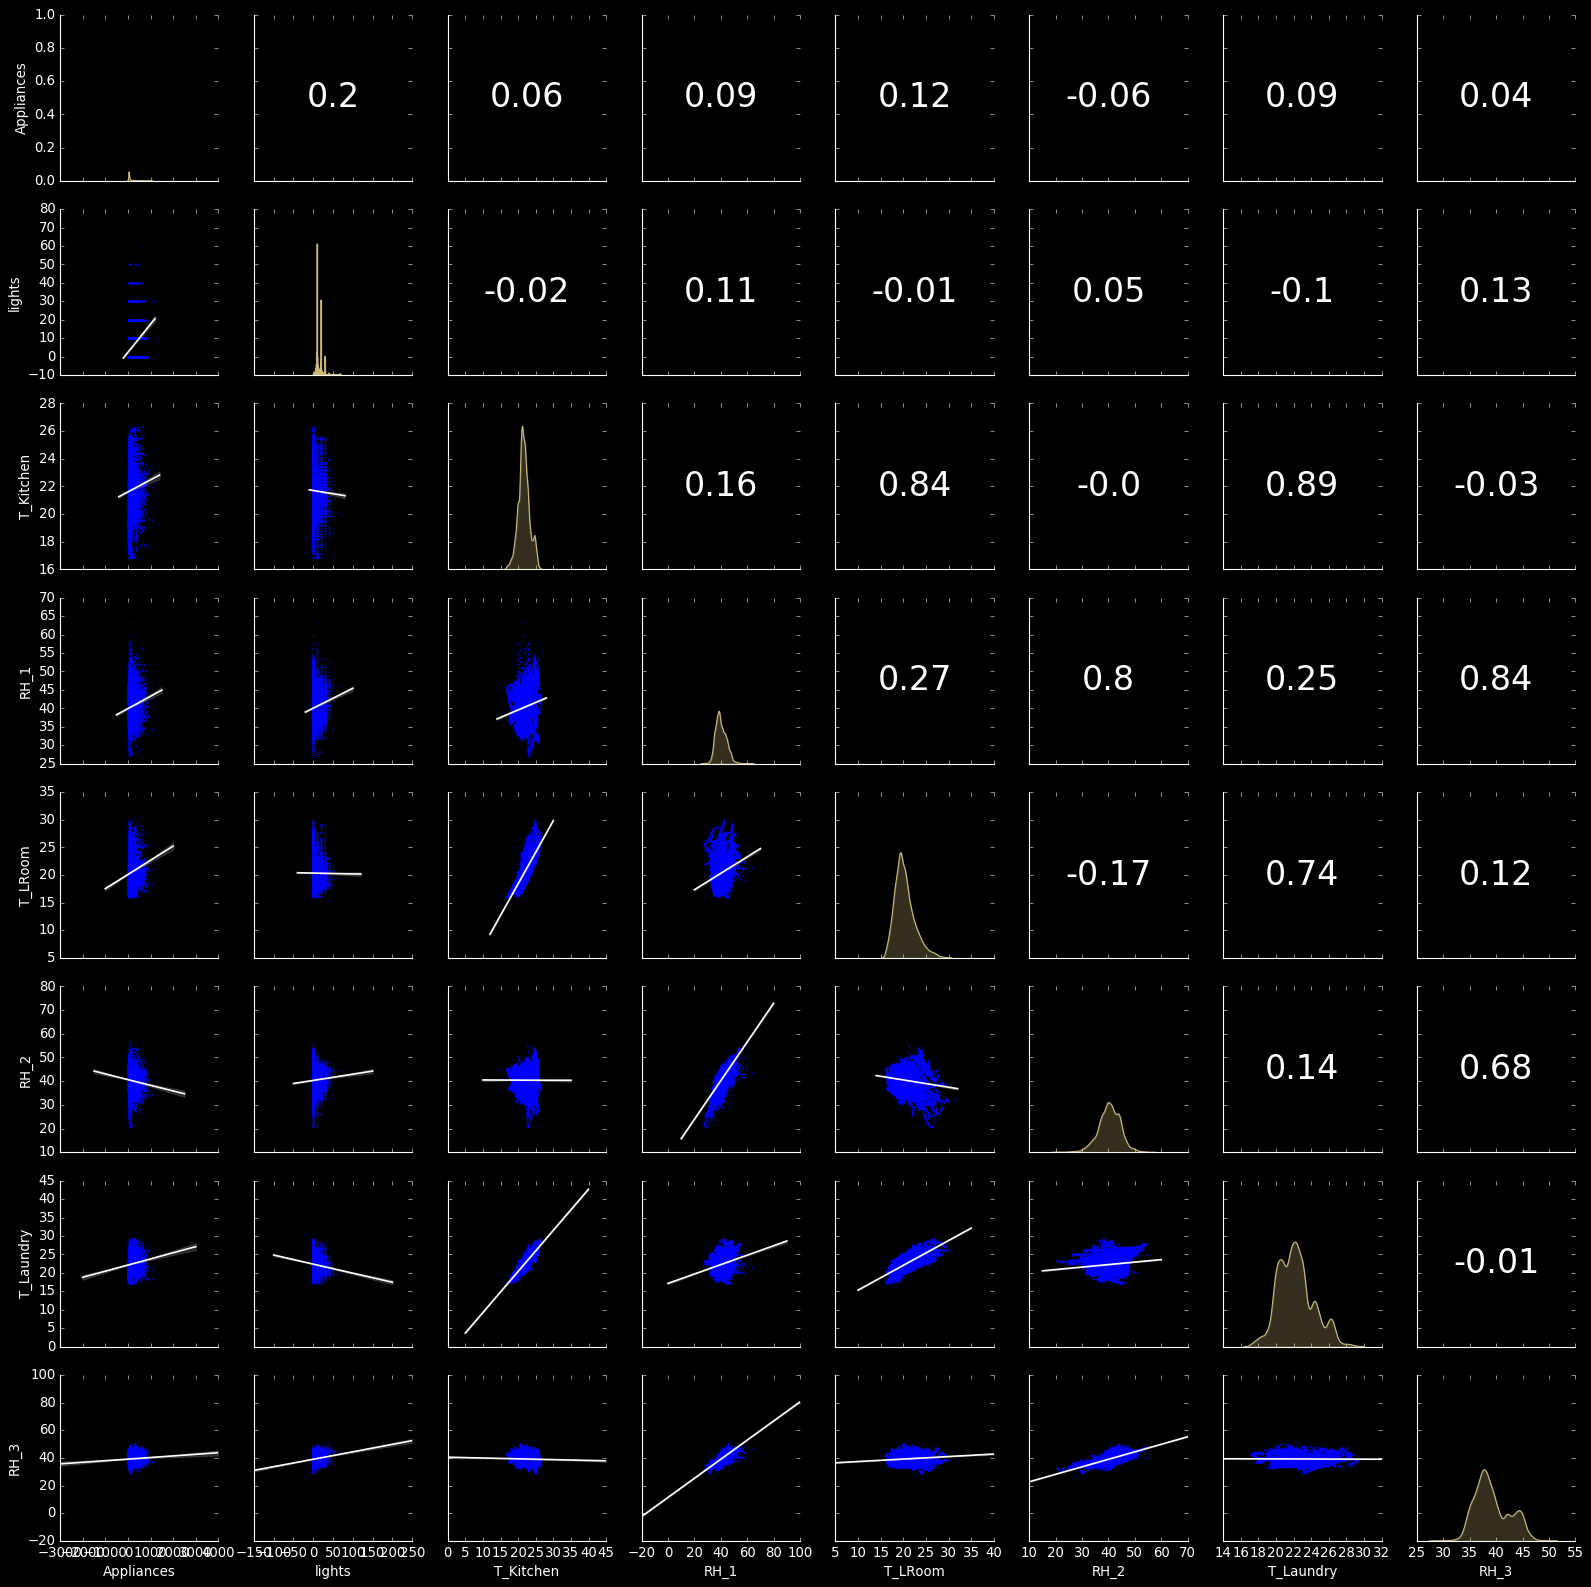

In [104]:
plt.style.use('dark_background')
dat1 = energy[['Appliances', 'lights', 'T_Kitchen', 'RH_1', 'T_LRoom', 'RH_2', 'T_Laundry', 'RH_3']]
prgrd = sns.PairGrid(dat1)
prgrd.map_diag(sns.kdeplot,shade = True, color = 'y')
prgrd.map_lower(sns.regplot, line_kws = {'color' : 'white'}, scatter_kws = {'color' : 'blue', 's' : 1})
def corrAnnotate(*args, **kwargs):
    corr = round(args[0].corr(args[1]), 2)
    ax = plt.gca()
    ax.annotate(corr, [.5, .5,],  xycoords="axes fraction", va='center', ha='center', size = 30)
prgrd.map_upper(corrAnnotate)

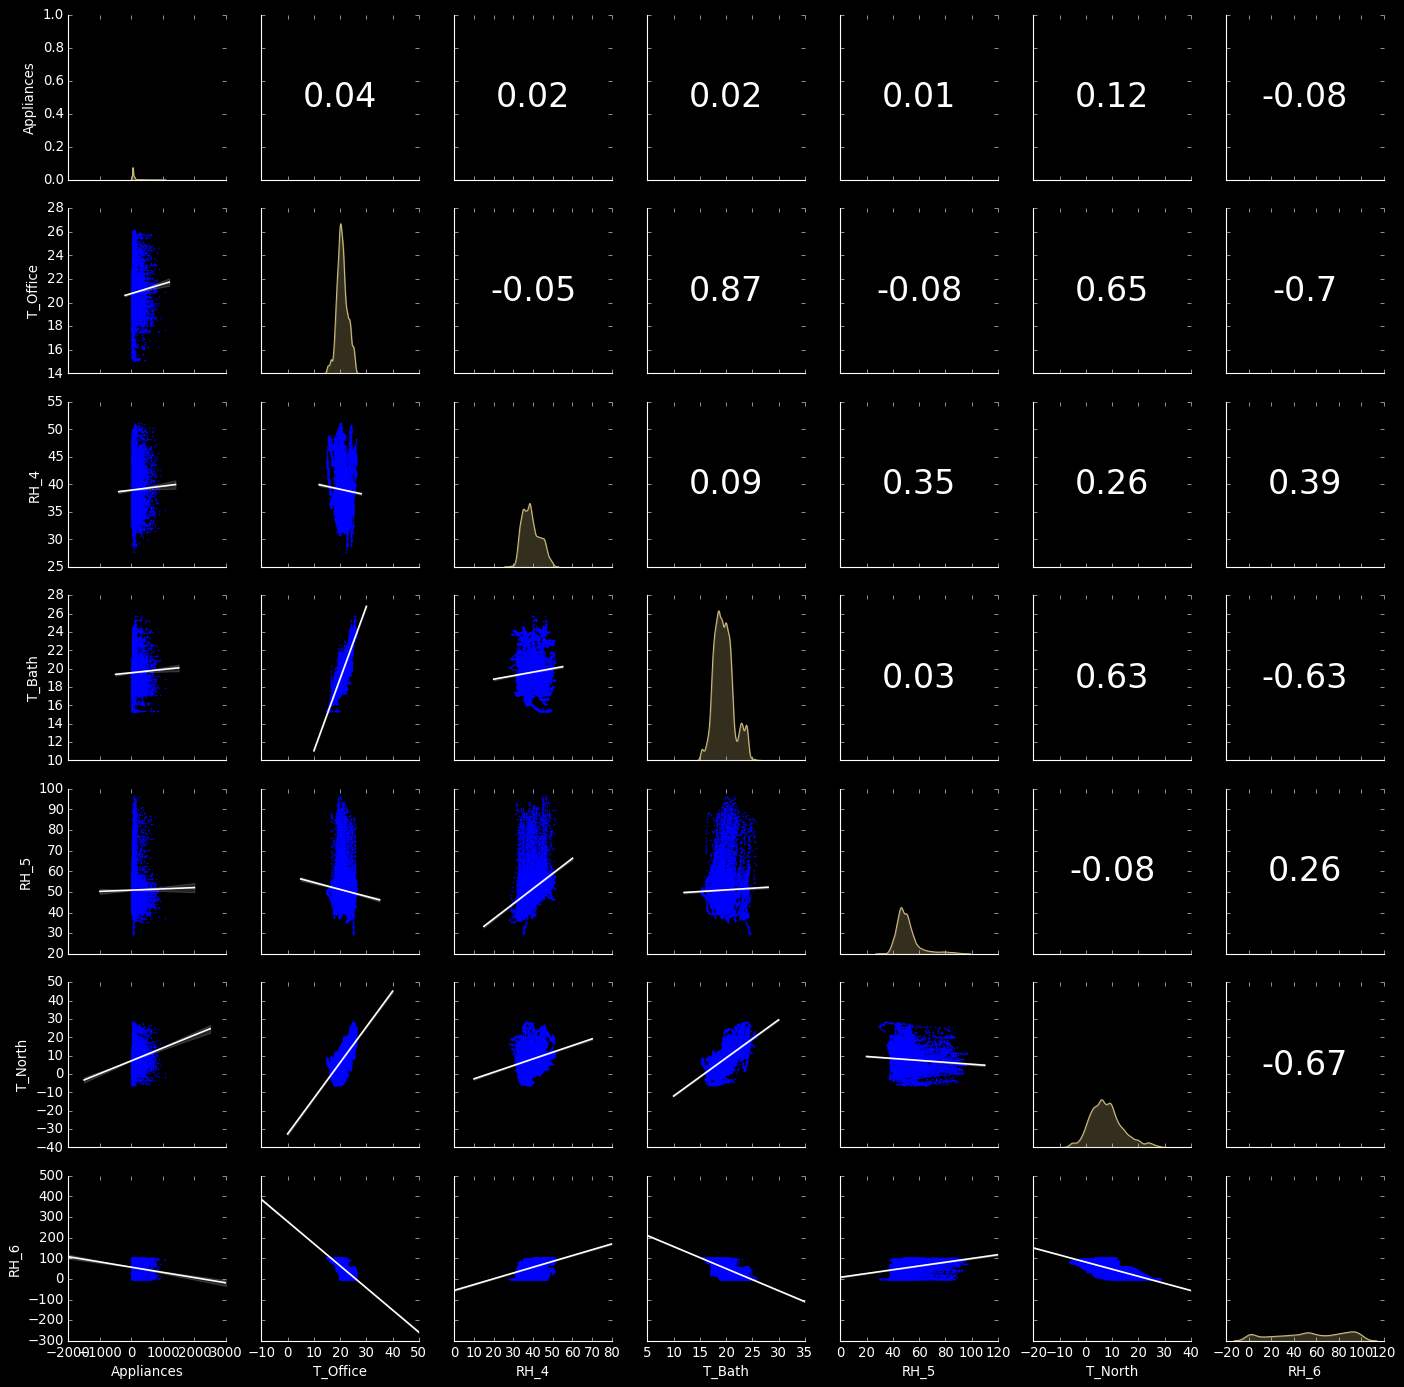

In [105]:
dat2 = energy[['Appliances', 'T_Office', 'RH_4', 'T_Bath', 'RH_5', 'T_North', 'RH_6']]
prgrd2 = sns.PairGrid(dat2)
prgrd2.map_diag(sns.kdeplot,shade = True, color = 'y')
prgrd2.map_lower(sns.regplot, line_kws = {'color' : 'white'}, scatter_kws = {'color' : 'blue', 's' : 1})
prgrd2.map_upper(corrAnnotate)

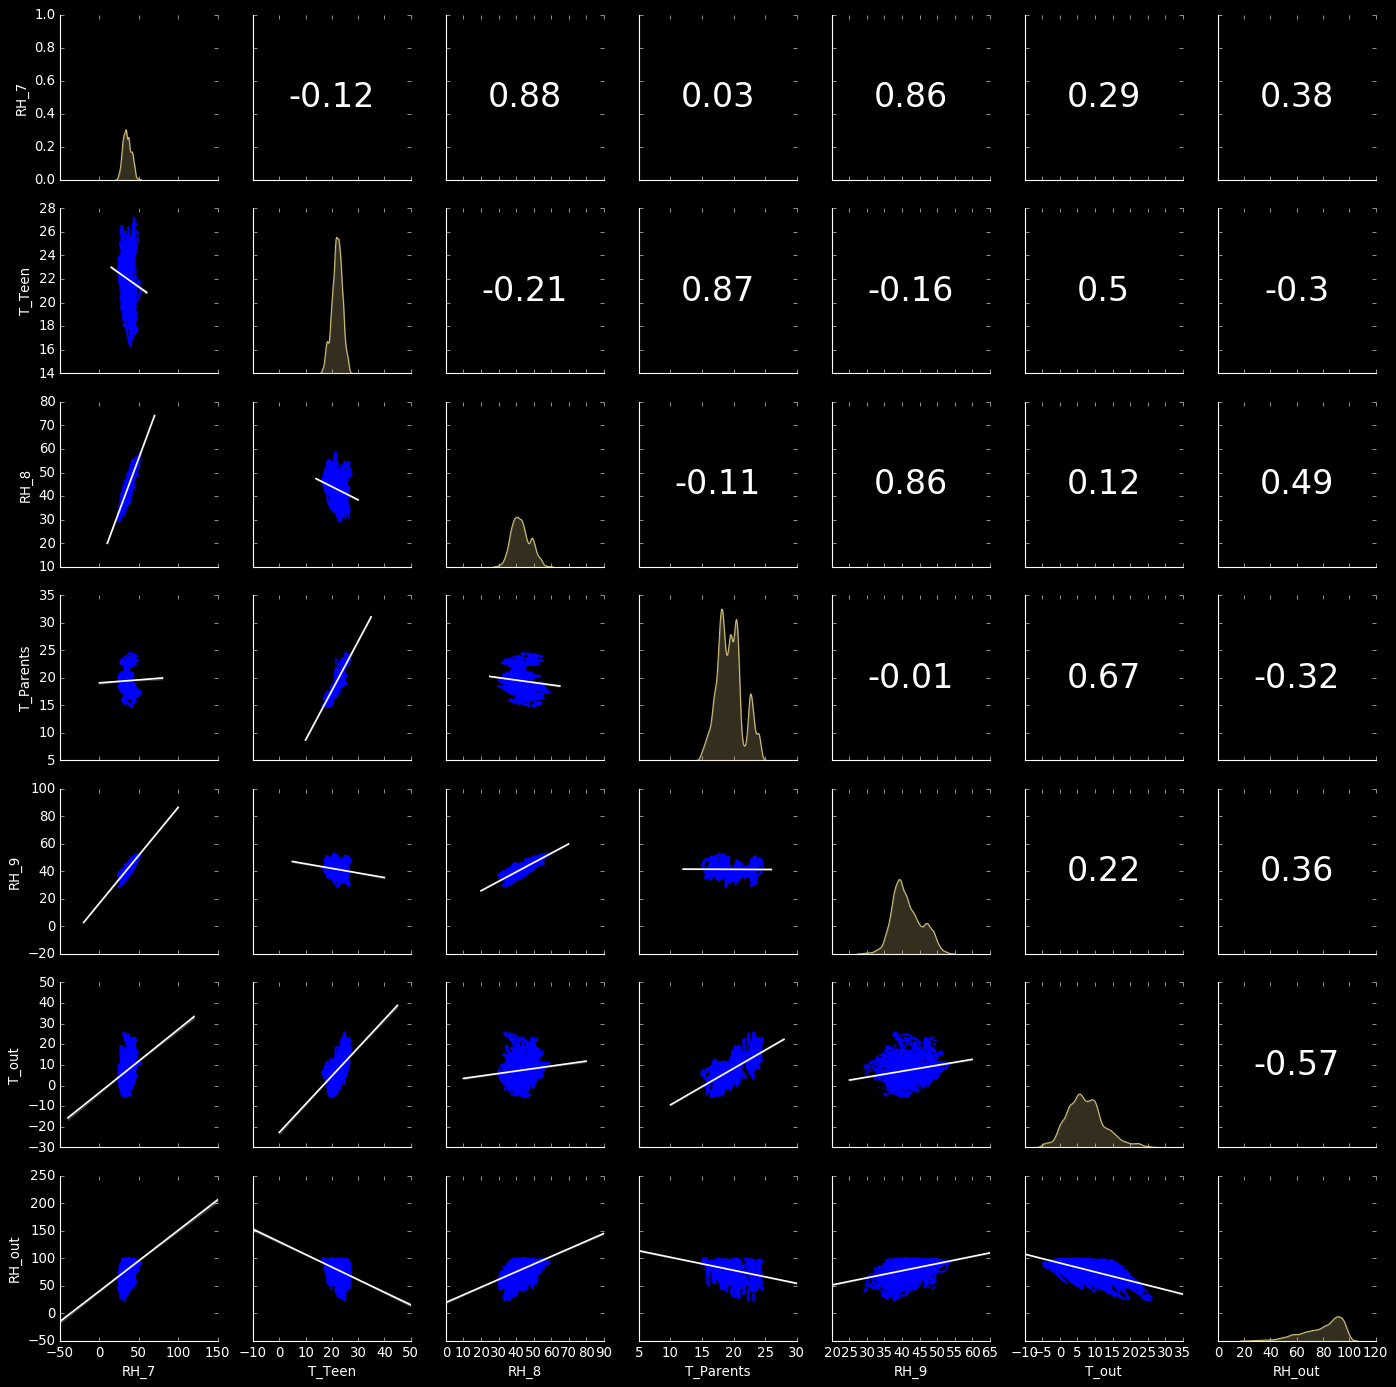

In [106]:
plt.style.use('dark_background')
dat1 = energy[['RH_7', 'T_Teen', 'RH_8', 'T_Parents', 'RH_9','T_out','RH_out']]
prgrd = sns.PairGrid(dat1)
prgrd.map_diag(sns.kdeplot,shade = True, color = 'y')
prgrd.map_lower(sns.regplot, line_kws = {'color' : 'white'}, scatter_kws = {'color' : 'blue', 's' : 1})
def corrAnnotate(*args, **kwargs):
    corr = round(args[0].corr(args[1]), 2)
    ax = plt.gca()
    ax.annotate(corr, [.5, .5,],  xycoords="axes fraction", va='center', ha='center', size = 30)
prgrd.map_upper(corrAnnotate)

In [107]:
print("End of Portfolio")

End of Portfolio


# Portfolio 3

K-means clustering is one of the simplest and popular unsupervised learning algorithms. Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes. This notebook illustrates the process of K-means clustering by generating some random clusters of data and then showing the iterations of the algorithm as random cluster means are updated. 

We first generate random data around 4 centers.

In [108]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

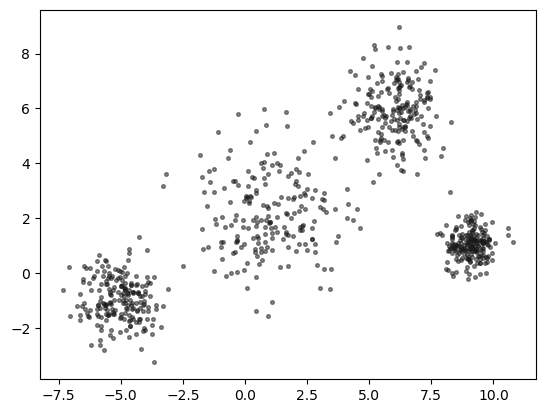

In [109]:
center_1 = np.array([1,2])
center_2 = np.array([6,6])
center_3 = np.array([9,1])
center_4 = np.array([-5,-1])
plt.style.use('default')
# Generate random data and center it to the four centers each with a different variance
np.random.seed(5)
data_1 = np.random.randn(200,2) * 1.5 + center_1
data_2 = np.random.randn(200,2) * 1 + center_2
data_3 = np.random.randn(200,2) * 0.5 + center_3
data_4 = np.random.randn(200,2) * 0.8 + center_4

data = np.concatenate((data_1, data_2, data_3, data_4), axis = 0)

plt.scatter(data[:,0], data[:,1], s=7, c='k', alpha = 0.5)
plt.show()

## 1. Generate random cluster centres

You need to generate four random centres.

This part of portfolio should contain at least:  
- The number of clusters `k` is set to 4;
- Generate random centres via `centres = np.random.randn(k,c)*std + mean` where `std` and `mean` are the standard deviation and mean of the data. `c` represents the number of features in the data. Set the random seed to 6.
- Color the generated centers with `green`, `blue`, `yellow`, and `cyan`. Set the edgecolors to `red`.

In [110]:
import random
k = 4
std = np.std(data)
mean = np.mean(data)


In [111]:
np.random.seed(6)
centres = np.random.randn(k,2)*std + mean
centres

array([[ 1.0430169 ,  5.53863665],
       [ 3.33061168, -1.4938254 ],
       [-8.35175241,  6.33448312],
       [ 7.25803215, -4.15028729]])

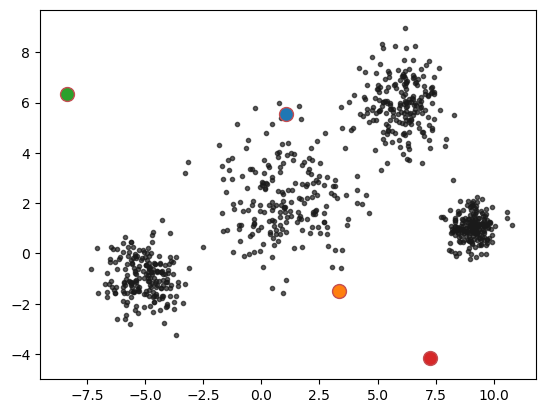

In [112]:
for point in data:
    plt.scatter(point[0], point[1], c = 'k', alpha = 0.7, s = 9)
for centre in centres:
    plt.scatter(centre[0], centre[1], edgecolors='r', s = 100)

## 2. Visualise the clustering results in each iteration

### *Explanation of K-Means Algorithm* ###

The k-means algorithm comprises of 3 functions : **euclidean**, **\_4means\_clustering** and **centre_updates**

#### *Euclidean*####

Takes two arguments *datapoints* and *centre*. Datapoints should be an array of points on the 2-d plane in the (x,y) format, while *centre* should be a singular point. It calculates the Euclidean distance between two points, which is given by the formula:

<center>$ D = \sqrt{(x-a)^2 + (y-b)^2)} $ </center>

where $ (x,y) $ are the coordinates of the centre, while the point $ P $ is located at $ (a,b) $ . The function returns *distlist*, a list containing the euclidean distance of each datapoint from the centre

#### *\_4means\_clustering*####

This function is used specifically for this case of k-means clustering with $ k = 4 $. It takes the parameters *datapoints* (similar to datapoints parameter of euclidean), and *centrepoints*, a numpy array containing the 4 centres' coordinates. It makes use of the euclidean function to create 4 numpy arrays, containing the distance of each datapoint from each of the 4 centres. 

It then compares each element of the resulting 4 arrays, with elements of the same index (i.e. first element across all arrays, second element across all arrays and so on), and appends the minimum value from the distances to a list.

Then we create 4 boolean lists, which indicate whether the point was closest to centre 1, centre 2, centre 3, or centre 4. It fills True for whichever centre it is closest to, and false otherwise. 

Then it appends the points which are closer to centre 1 under cluster 1 and so on. 

We now have 4 lists, representing the 4 clusters, each containing coordinates of all points which fall into that cluster. We store these as numpy arrays :*first, second, third and fourth.*

We then plot these points according to the color code:

| Cluster | Color |
| --- | --- | 
| 1 | Green |
| 2 | Blue |
| 3 | Yellow |
| 4 | Cyan |


#### *centre_updates* ####

This function is responsible for plotting and updating centres. It is to be noted\* that from the second iteration onwards, the centre_updates function is responsible for plotting the data and centres, and also updating the centres. It also stores value of previous centres in the list *centre_history*

Centres are updated by taking the mean value of all points of a cluster, and assigning them to a variable. This variable is then appended to a new global variable - *newcentres*, which stores the new centres in an array format. The function also contains a call to the \_4means\_clustering function. Due to this, the function is able to plot the data along with the centres, and update the centres. 


<small> \**Note that in the first iteration, our centres were already defined, and hence there was no need to update centres*

In [113]:
centre_history = []

In [114]:
def euclidean (datapoints, centre):
    ##Calculate Euclidean distance between all points in data and a particular centre
    distlist = []
    for point in datapoints:
        distlist.append(round(np.linalg.norm(point-centre), 5))
    return distlist

In [115]:
def _4means_clustering(datapoints, centrepoints):
    dist1 = np.array(euclidean(data, centrepoints[0]))
    dist2 = np.array(euclidean(data, centrepoints[1]))
    dist3 = np.array(euclidean(data, centrepoints[2]))
    dist4 = np.array(euclidean(data, centrepoints[3]))
    z = []
    for i in range(len(dist1)):
        z.append(min(dist1[i], dist2[i], dist3[i], dist4[i]))
    in_1 = []
    in_2 = []
    in_3 = []
    in_4 = []
    for item in z:
        in_1.append(item in dist1)
        in_2.append(item in dist2)
        in_3.append(item in dist3)
        in_4.append(item in dist4)
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    for i in range(len(data)):
        if (in_1[i]):
            cluster1.append(data[i])
        elif(in_2[i]):
            cluster2.append(data[i])
        elif(in_3[i]):
            cluster3.append(data[i])
        elif(in_4[i]):
            cluster4.append(data[i])
    global first, second, third, fourth ##Create global variables indicating first, second, third, fourth clusters
    first = np.array(cluster1)
    second = np.array(cluster2)
    third = np.array(cluster3)
    fourth = np.array(cluster4)

    
    ##Plot clusters as per color code
    for dot in data:
        if (dot in first):
            plt.scatter(dot[0], dot[1], c = 'green')
        elif (dot in second):
            plt.scatter(dot[0], dot[1], c = 'blue')
        elif (dot in third):
            plt.scatter(dot[0], dot[1], c = 'yellow')
        elif (dot in fourth):
            plt.scatter(dot[0], dot[1], c = 'cyan')

In [116]:
def centre_updates():
    global newcentres ##New centres
    c1 = np.array([first[:,0].mean(), first[:,1].mean()])
    c2 = np.array([second[:,0].mean(), second[:,1].mean()])
    c3 = np.array([third[:,0].mean(), third[:,1].mean()])
    c4 = np.array([fourth[:,0].mean(), fourth[:,1].mean()])
    centrelist = [c1,c2,c3,c4]
    
    
    newcentres = np.array(centrelist)
    
    _4means_clustering(data, newcentres)
    
    ##Plot centers as per color code
    plt.scatter(newcentres[0][0], newcentres[0][1], c = 'green', edgecolors='r', s = 70)
    plt.scatter(newcentres[1][0], newcentres[1][1], c = 'blue', edgecolors='r', s = 70)
    plt.scatter(newcentres[2][0], newcentres[2][1], c = 'yellow', edgecolors='r', s = 70)
    plt.scatter(newcentres[3][0], newcentres[3][1], c = 'cyan', edgecolors='r', s = 70)
    centre_history.append(newcentres)

(None, None)

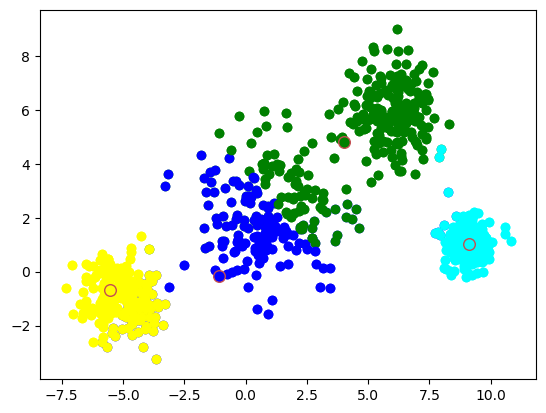

In [117]:
_4means_clustering(data, centres), centre_updates()

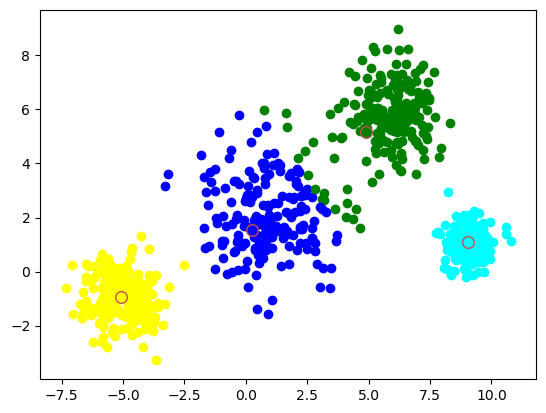

In [118]:
centre_updates()

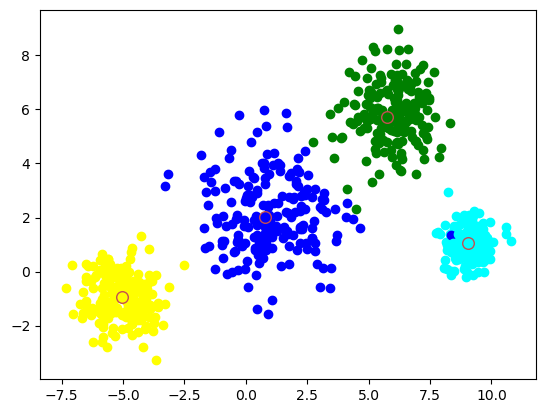

In [119]:
centre_updates()

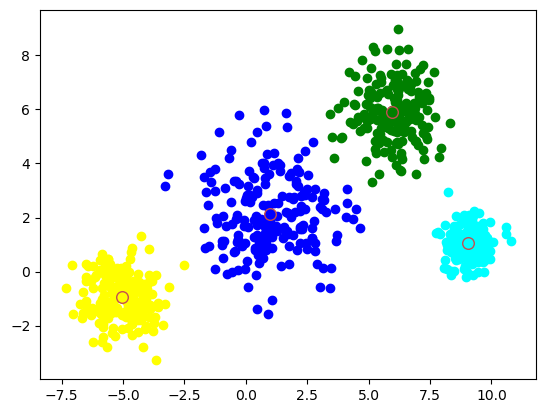

In [120]:
centre_updates()

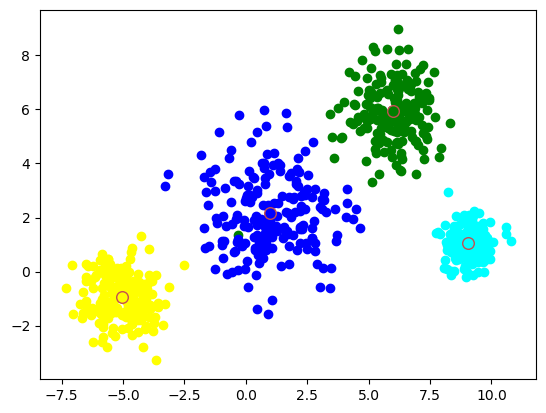

In [121]:
centre_updates()

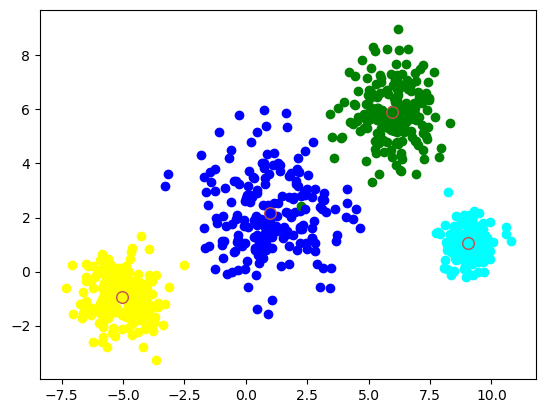

In [122]:
centre_updates()

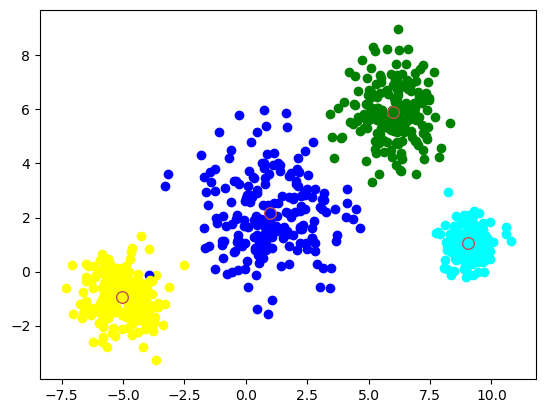

In [123]:
centre_updates()

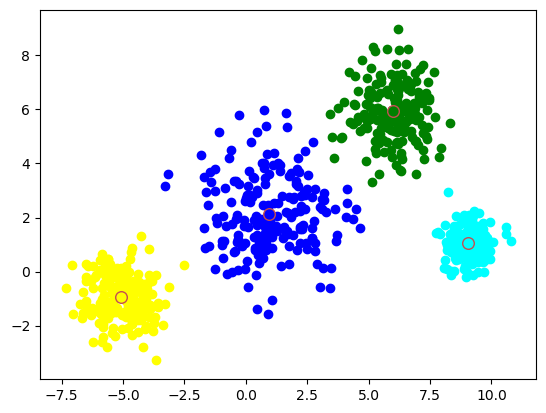

In [124]:
centre_updates()

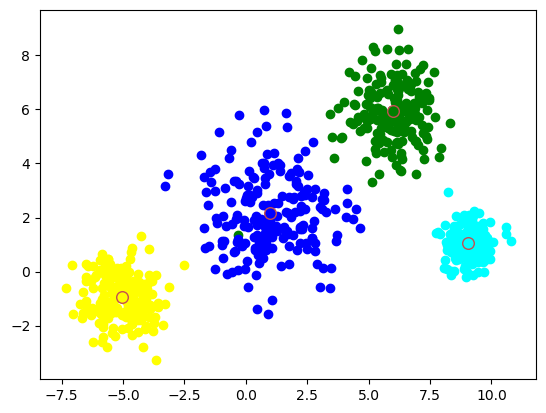

In [125]:
centre_updates()

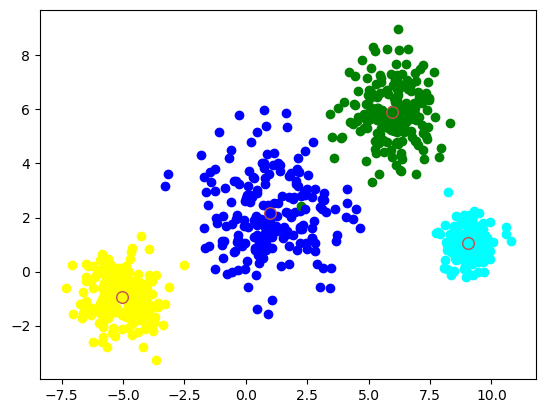

In [126]:
centre_updates()

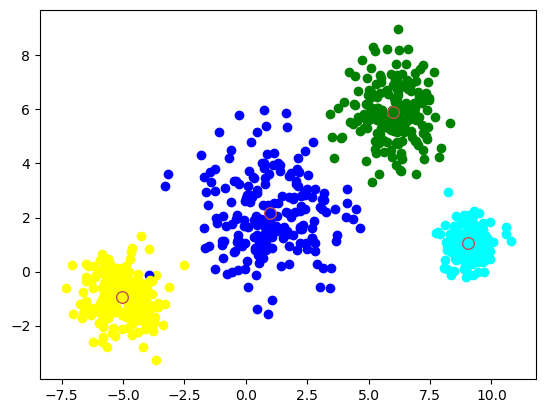

In [127]:
centre_updates()

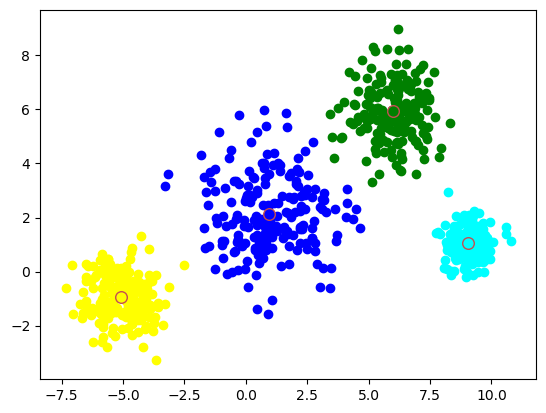

In [128]:
centre_updates()

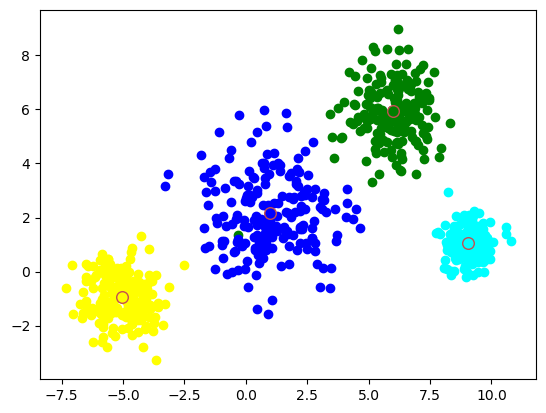

In [129]:
centre_updates()

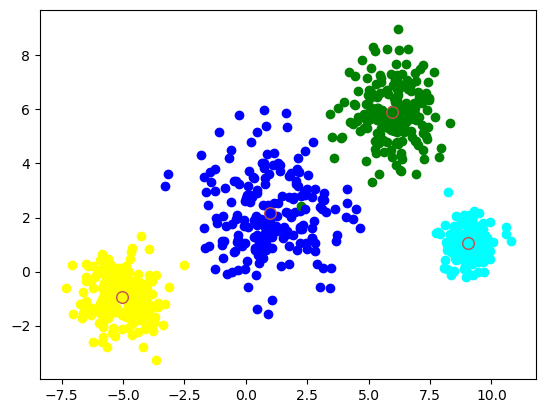

In [130]:
centre_updates()

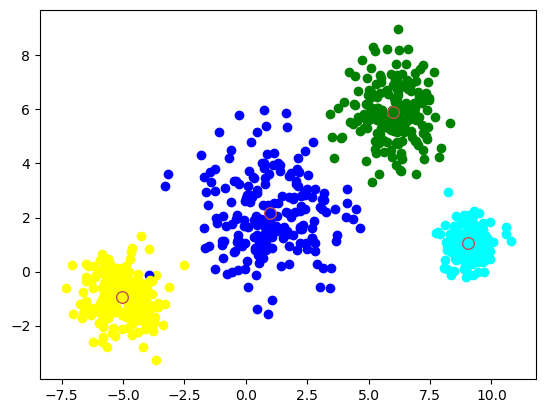

In [131]:
centre_updates()

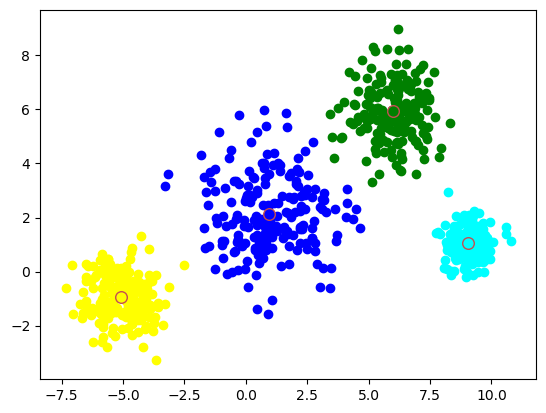

In [132]:
centre_updates()

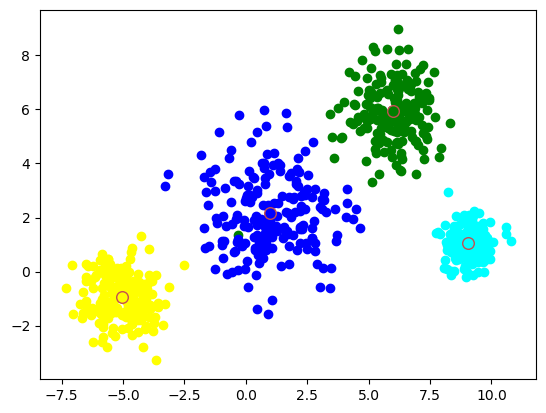

In [133]:
centre_updates()

In [135]:
print(centre_history[-1] - centre_history[-2])

[[0.         0.        ]
 [0.02492071 0.01154679]
 [0.00550173 0.004086  ]
 [0.         0.        ]]


After *18* iterations, we can see that 2 of the 4 centres do not move, whereas the other two move by a distance of the order $ (10^{-2}) $. Hence, we can say that the clustering algorithm has reached a *saturation point*.